## Import libraries


In [2]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import re
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize  
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sc
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances as p_dist

In [2]:
!pip install wrapt --upgrade --ignore-installed
!pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/68/8c/42bbb31a25a708e2e24881724ec7bcea05530492de8b1a2e0d8fe43eb2f6/tensorflow-2.4.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl


## Explore data

In [3]:
#pd.set_option('display.max_columns',None)
df = pd.read_csv("C:/Users/Gunisha Chaturvedi/Dropbox/My PC (LAPTOP-1CT80JS5)/Documents/minor/WDIEXCEL2.csv")
df.head()

,Country_Name,Country Code,Indicator_Name,Indicator_Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,82.783289,83.120303,83.533457,83.897596,84.171599,84.510171,NaN,NaN,NaN,NaN
1,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,87.199474,87.512260,88.129881,87.275323,88.720097,89.308602,90.283638,89.286856,NaN,NaN
2,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,75.958878,77.251714,78.165706,75.512153,78.211000,79.065508,81.102134,79.248100,NaN,NaN
3,Arab World,ARB,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,96.466418,96.435957,96.772853,96.466705,96.936319,97.290083,97.467915,97.063959,NaN,NaN
4,Arab World,ARB,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,22.260538,NaN,NaN,30.277130,NaN,NaN,37.165211,NaN,NaN,NaN


In [3]:
print("Shape:",df.shape)

#get unique indicator values
indi_unique = len(list(df.Indicator_Name.unique()))
print("Unique indicators:",indi_unique)

#get unique indicator names
country_unique = len(list(df.Country_Name.unique()))
print("Unique countries:",country_unique)

#frequency of each unique indicator
print("Frequency of each indicator:",df['Indicator_Name'].value_counts())

Shape: (132948, 65)
Unique indicators: 1440
Unique countries: 133
Frequency of each indicator: Agricultural methane emissions (thousand metric tons of CO2 equivalent)                                                   133
Rural population                                                                                                          133
Renewable electricity output (% of total electricity output)                                                              133
Population, total                                                                                                         133
Rural population (% of total population)                                                                                  133
People practicing open defecation (% of population)                                                                       133
Land area (sq. km)                                                                                                        133
Nitrous oxide emissions

### It can be concluded that the distribution of indicators is uneven because some rows have been removed from the original dataset as a part of cleaning.

## Clean data 

In [3]:
#check for rows which have null values for all years 
df1=df[df.loc[:,'1960':'2020'].isnull().all(axis=1)]

#get column wise sum of null values
print(df.isnull().sum().sort_values(ascending=False))

#remove those rows
df.drop(list(df1.index),inplace=True)
print(df.shape)
df.to_csv('C:/Users/hp1/Documents/minor/WDIEXCEL2.csv')

In [4]:
def clean_data(df_new):
    stop_words = set(stopwords.words('english'))
    for i in range(0,df_new.size):
        df_new[i]=re.sub('\(.*?\)',"",df_new[i])        #remove content within brackets
        df_new[i] = re.sub(r'[^\w\s]',"", df_new[i])    #remove punctuations
        df_new[i]= re.sub('\d',"",df_new[i])           #remove numbers
        word_tokens = word_tokenize(df_new[i])
        df_new[i]=" ".join(filter(lambda x: x not in stop_words , word_tokens))   #remove stop words
    return df_new

In [5]:
unique_indicators = df.Indicator_Name.unique()
unique_indicators = clean_data (unique_indicators)
unique_indicators

array(['Access clean fuels technologies cooking', 'Access electricity',
       'Access electricity rural', ..., 'Net ODA provided total',
       'Net primary income', 'Female genital mutilation prevalence'],
      dtype=object)

### Trying word2vec on data

In [6]:
text_data = unique_indicators.tolist()
text_data

['Access clean fuels technologies cooking',
 'Access electricity',
 'Access electricity rural',
 'Access electricity urban',
 'Account ownership financial institution mobilemoneyservice provider',
 'Account ownership financial institution mobilemoneyservice provider female',
 'Account ownership financial institution mobilemoneyservice provider male',
 'Account ownership financial institution mobilemoneyservice provider older adults',
 'Account ownership financial institution mobilemoneyservice provider poorest',
 'Account ownership financial institution mobilemoneyservice provider primary education less',
 'Account ownership financial institution mobilemoneyservice provider richest',
 'Account ownership financial institution mobilemoneyservice provider secondary education',
 'Account ownership financial institution mobilemoneyservice provider young adults',
 'Adjusted net enrollment rate primary',
 'Adjusted net enrollment rate primary female',
 'Adjusted net enrollment rate primary ma

In [7]:
def convert (text_data):
    for i in range (0,len(text_data)):
        text_data[i] = text_data[i].split()
    return text_data
text_data = convert (text_data)
text_data

[['Access', 'clean', 'fuels', 'technologies', 'cooking'],
 ['Access', 'electricity'],
 ['Access', 'electricity', 'rural'],
 ['Access', 'electricity', 'urban'],
 ['Account',
  'ownership',
  'financial',
  'institution',
  'mobilemoneyservice',
  'provider'],
 ['Account',
  'ownership',
  'financial',
  'institution',
  'mobilemoneyservice',
  'provider',
  'female'],
 ['Account',
  'ownership',
  'financial',
  'institution',
  'mobilemoneyservice',
  'provider',
  'male'],
 ['Account',
  'ownership',
  'financial',
  'institution',
  'mobilemoneyservice',
  'provider',
  'older',
  'adults'],
 ['Account',
  'ownership',
  'financial',
  'institution',
  'mobilemoneyservice',
  'provider',
  'poorest'],
 ['Account',
  'ownership',
  'financial',
  'institution',
  'mobilemoneyservice',
  'provider',
  'primary',
  'education',
  'less'],
 ['Account',
  'ownership',
  'financial',
  'institution',
  'mobilemoneyservice',
  'provider',
  'richest'],
 ['Account',
  'ownership',
  'financi

In [8]:
model = Word2Vec(text_data, min_count=1, size=4)

In [9]:
model.save('model1')

In [65]:
len(model.wv.vocab)

1127

In [14]:
model.wv.most_similar ('government')

[('Suicide', 0.9895569086074829),
 ('documentary', 0.9814968109130859),
 ('Survival', 0.9715716242790222),
 ('UNRWA', 0.9706627726554871),
 ('loans', 0.968593955039978),
 ('Imports', 0.9677640199661255),
 ('Gross', 0.957078218460083),
 ('shipments', 0.9545134902000427),
 ('Market', 0.9509927034378052),
 ('food', 0.9504662752151489)]

In [12]:
model.wv['Access']

array([ 0.064179  ,  0.03314259, -0.00698101, -0.02683746], dtype=float32)

## Vectorisation

In [6]:
#apply tf-idf vectorization

v = tfidf()
v1 = v.fit_transform(unique_indicators)
arr = v1.toarray()

## PCA and k-means

In [7]:
pca = PCA (n_components=2)
pcom = pca.fit_transform(arr)
principaldf = pd.DataFrame(data = pcom, columns = ['x', 'y'])
principaldf.head()

,x,y
0,-0.053093,-0.003928
1,-0.058078,-0.005259
2,-0.052967,-0.004277
3,-0.051594,-0.003552
4,-0.067034,0.024567


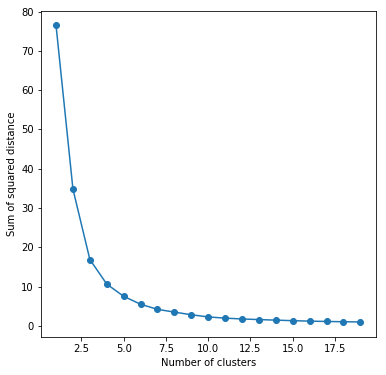

In [8]:
#implement elbow method

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(principaldf)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters')
plt.ylabel('Sum of squared distance');

In [9]:
#apply k-means

Kmean = KMeans (n_clusters = 5,random_state=0)
cluster=Kmean.fit_predict (principaldf)

In [12]:
cluster = pd.Series(cluster)

In [22]:
df2 = pd.concat([df.loc[0:1439,'Indicator_Name'], cluster], axis=1)

In [24]:
df2.tail()

,Indicator_Name,0
1435,"Personal remittances, received (current US$)",4
1436,"Personal transfers, receipts (BoP, current US$)",4
1437,"Physicians (per 1,000 people)",4
1438,"Plant species (higher), threatened",4
1439,"PM2.5 air pollution, mean annual exposure (mic...",3


In [28]:
df2.to_csv('C:\\Users\\Gunisha Chaturvedi\\Dropbox\\My PC (LAPTOP-1CT80JS5)\\Documents\\minor\\newclusters.csv')

In [25]:
new_df = pd.concat([principaldf,cluster], axis=1)
new_df.rename(columns={0:'Cluster'},inplace=True)
new_df.head()

,x,y,Cluster
0,-0.053093,-0.003928,0
1,-0.058078,-0.005259,0
2,-0.052967,-0.004277,0
3,-0.051594,-0.003552,0
4,-0.067034,0.024567,0


In [30]:
cluster.head(20)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    4
17    4
18    4
19    4
dtype: int32

In [47]:
unique_indicators_df = pd.DataFrame (unique_indicators, columns= ['Indicator_Name'])

In [52]:
df_final = pd.concat ([unique_indicators_df, new_df], axis=1)

In [55]:
df_final.head()

,Indicator_Name,x,y,Cluster
0,Access clean fuels technologies cooking,-0.053096,-0.003290,1
1,Access electricity,-0.058083,-0.004177,1
2,Access electricity rural,-0.052971,-0.002681,1
3,Access electricity urban,-0.051598,-0.001911,1
4,Account ownership financial institution mobile...,-0.067046,0.026517,1


## Evaluation metrics- Dunn Index and Silhouette Score

In [58]:
#code to calculate numerator
#calculate pairwise distances between cluster centers

centers = Kmean.cluster_centers_
d_mat = p_dist(centers, metric= 'euclidean')

#remove duplicates and get min distance
d_mat_unique = set(d_mat.flatten()) 
d_mat_unique.remove(0)
inter_cluster_dist = min(d_mat_unique)

In [60]:
#code to calculate denominator

dist_list = []
n_clusters = 5
for j in range(0,n_clusters):
    cluster_points = df_final[['x','y']][df_final['Cluster']== j]
    dist_mat = p_dist (cluster_points)
    dist_mat_unique = set(dist_mat.flatten()) 
    max1 = max(dist_mat_unique)
    dist_list.append (max1)

intra_cluster_dist = max(dist_list)
d_index = (inter_cluster_dist/intra_cluster_dist)
print (d_index)

0.39687119734012266


In [61]:
#calculate silhouette score
print(sc(principaldf,cluster))

0.6411448775523271


## Visualize clusters

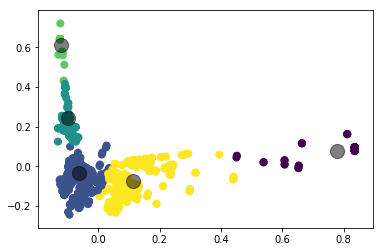

In [62]:
plt.scatter(df_final['x'], df_final['y'], c=cluster, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Visualisations

In [ ]:
#stacked bar graph

df1=df.where((df['Indicator_Code']=='SL.TLF.0714.WK.ZS') | (df['Indicator_Code']=='SL.TLF.0714.SW.ZS'))
df1.dropna(how='all',inplace=True)
print(df1.shape)
print(df1.head(10))
df1.to_csv('C:/Users/hp1/Documents/minor/education1.csv')